In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

import pandas as pd
import numpy as np
import xarray as xr
import tifffile 
from tqdm import tqdm_notebook as tqdm
import matplotlib.colors as colors
import matplotlib.cm as cmx

Populating the interactive namespace from numpy and matplotlib


/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from scipy import stats
from deepflow.plotting_utils import colorbar, load_folders, create_simulation_time_axis
from deepflow.plotting_utils import get_unconditionals, determine_connected
from deepflow.plotting_utils import plot_misfit_histograms, get_reference_curves, extract_curves
from deepflow.plotting_utils import inverse_permeability_transform, load_gt_model_from_numpy
from deepflow.plotting_utils import update_matplotlib_config, plot_colored_rate_curves
update_matplotlib_config()

True

## Loading all the data for case 66

In [3]:
plot = False
working_dir = './results/runs/'
perm = "low_perm"
case = 66

#Creates the simulation time axis
dts = create_simulation_time_axis()

ref_curves = get_reference_curves(working_dir, perm, case='/reference/reference_noise.nc')

#Load the ground truth case from the test set, corresponds to test set model 67
envelope = load_gt_model_from_numpy("./reference/model_67_x.npy")

In [4]:
qor_curves, qwr_curves, p_curves, perms, material_grads, poros = extract_curves("./results/runs/paper/low_perm_flowwells_adam_gauss_bce/run_"+str(case)+"/")

100%|██████████| 500/500 [01:04<00:00,  6.72it/s]


In [5]:
facies = np.array([np.where(inverse_permeability_transform(p)>0.5, 1, 0)[::-1] for p in perms])
curves = np.swapaxes(np.array([qor_curves, qwr_curves, p_curves]), 0, 1)

In [6]:
misfits_flowwells = np.load("./results/misfits/low_perm/misfits_flowwells_adam_gauss_bce.npy")

In [7]:
misfits_case = misfits_flowwells[case][:, [3, 4, -1]]

errors = [[0, *misfits_case[0]]]
for i, (error) in enumerate(misfits_case):
    if error[2] < errors[-1][3]:
        errors.append([i, error[0], error[1], error[2]])
        
errors = np.array(errors)
curves_case = curves[errors[:, 0].astype(int)]
selected_iteration = [0, 33, 43, -4, -3, -1]
selected_errors = np.stack([errors[selected_iteration, 0], errors[selected_iteration, 1]], 1)

## Plot the loss evolution for case 66

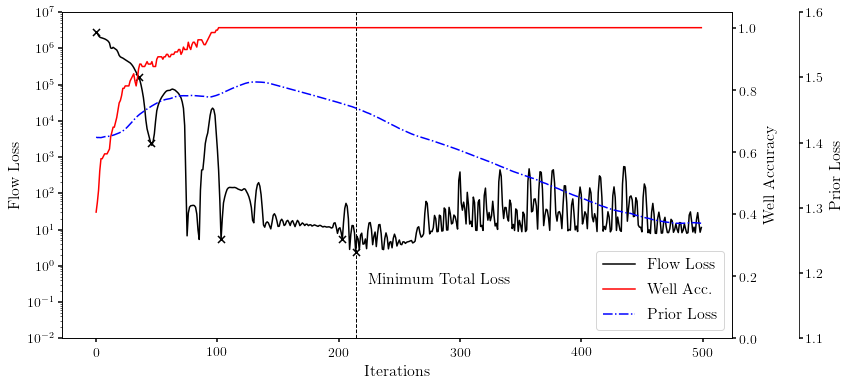

In [8]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

f = 16
fig, host = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(right=0.9)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))

make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)


p1, = host.plot(range(500), misfits_flowwells[case][:, 3], color="black", linestyle="-", label="Flow Loss")#, c=colors, s=1)
host.set_ylabel("Flow Loss", fontsize=f)
p2, = par1.plot(misfits_flowwells[case][:, 4], color="red", linestyle="-", label="Well Acc.")
par1.set_ylabel("Well Accuracy", fontsize=f)
p3, = par2.plot(misfits_flowwells[case][:, 6], color="blue", linestyle="-.", label="Prior Loss")
par2.set_ylabel("Prior Loss", fontsize=f)

host.set_yscale("log")
host.set_xlabel("Iterations", fontsize=16)
par1.set_ylim(0, 1.05)
par2.set_ylim(1.1, 1.6)
host.set_ylim(1e-2, 1e7)

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p1.get_color())
par2.yaxis.label.set_color(p1.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p1.get_color(), **tkw)
par2.tick_params(axis='y', colors=p1.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

host.scatter(selected_errors[:, 0], selected_errors[:, 1], marker="x", s=50, color="black")


lines = [p1, p2, p3]
host.axvline(np.max(errors[:, 0]), linestyle="--", linewidth=1, color="black")
host.text(np.max(errors[:, 0])+10, 3e-1, "Minimum Total Loss", fontsize=16)
host.legend(lines, [l.get_label() for l in lines], fontsize=16, loc=4)

if plot:
    plt.savefig("./results/figures/evolution_loss_functions.png", dpi=300, bbox_inches="tight")

## Plot the facies indicator evolution at the cross-markers 
## (manually picked minima and final minimum)

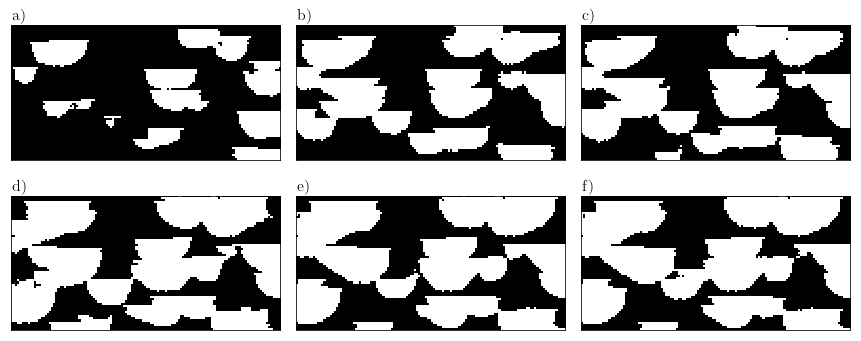

In [9]:
facies_case = facies[errors[:, 0].astype(int)]
facies_case_selected = facies_case[selected_iteration]

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
for a, im in zip(ax.flatten(), facies_case_selected):
    a.imshow(im, cmap="gray")
    a.set_xticks([])
    a.set_yticks([])

for a, label, left, up in zip(ax.flatten(), ["a)", "b)", "c)", "d)", "e)", "f)"], [0]*6, [66]*6):
    a.text(left, up, label, fontsize=16)    
    
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=-0.3)
if plot:
    plt.savefig("./results/figures/evolution_facies.png", dpi=300, bbox_inches="tight")

## Evolution of flow response as function of iteration and total loss

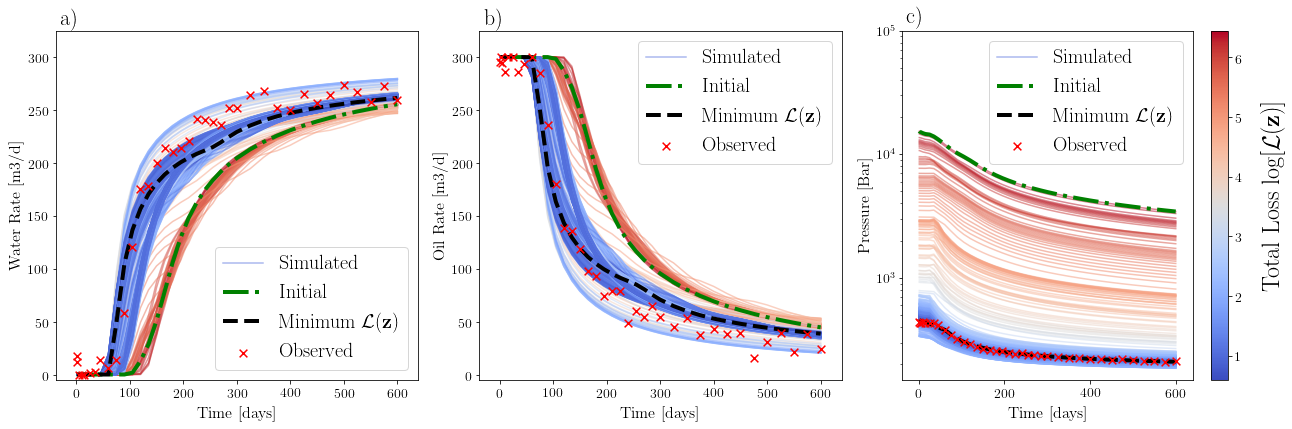

In [11]:
from deepflow.plotting_utils import plot_colored_rate_curves_loss

fig, axarr = plt.subplots(1, 3, figsize=(6*3, 6))

min_error = np.array([errors[-1, 0]]).astype(int)
#print(min_error)
colormap = plot_colored_rate_curves_loss(axarr, curves, misfits_case[:, -1], range(500), min_error, ref_curves, dts, cmap="coolwarm", ref_color="red")

fig.tight_layout()
if plot:
    plt.savefig("./results/figures/evolution_flowwells_case_66_new.png", dpi=300, bbox_inches="tight")

## Storing Animations (not used - only examplary)

In [100]:
tifffile.imsave('./results/figures/evolution_map2.tiff', facies.astype(np.float32)[:, ::-1])

In [101]:
tifffile.imsave('./results/figures/evolution_gradient2.tiff', material_grads[:, 0].astype(np.float32))
tifffile.imsave('./results/figures/evolution_gradient_normed.tiff', material_grads[:, 0].astype(np.float32)/np.linalg.norm(np.abs(material_grads[:, 0])))

## Additional Graphs for Overview Figure - Gradient of Porosity

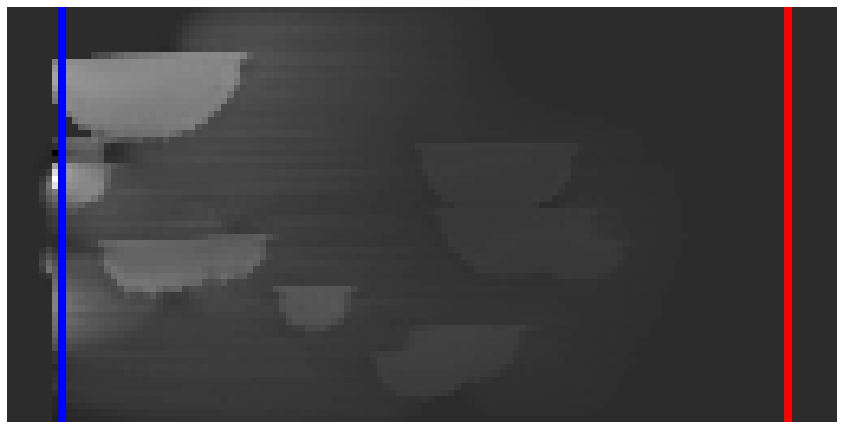

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
grad = material_grads[1, 0, ::-1]
sc1 = ax.imshow(grad/np.linalg.norm(np.abs(grad)), cmap="gray")
#colorbar(sc1)
ax.set_xticks([])
ax.set_yticks([])

ax.axvline(8, color="blue", linewidth=8)
ax.axvline(120, color="red", linewidth=8)
ax.set_axis_off()
fig.tight_layout()

if plot:
    plt.savefig("./results/figures/gradient_porosity_case_66_iteration_1.png", dpi=300, bbox_inches="tight")

## Additional Graphs for Overview Figure - Gradient of Permeability

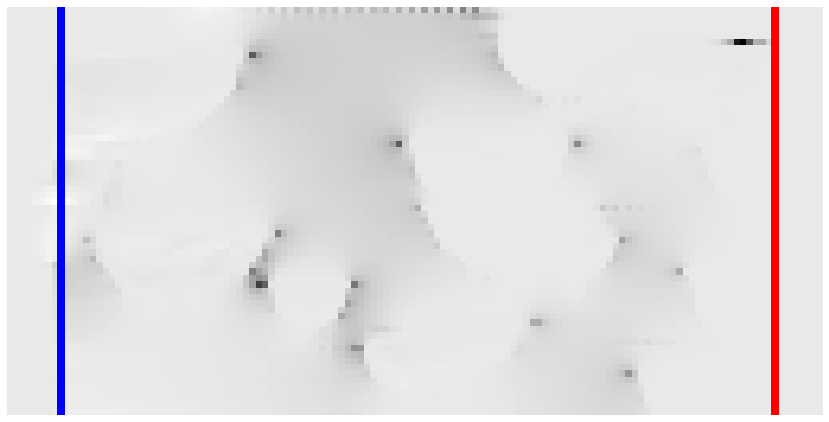

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
grad = material_grads[1, 1, ::-1]
sc1 = ax.imshow(grad/np.linalg.norm(np.abs(grad)), cmap="gray")
#colorbar(sc1)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

ax.axvline(8, color="blue", linewidth=8)
ax.axvline(120, color="red", linewidth=8)
ax.set_axis_off()
if plot:
    plt.savefig("./results/figures/gradient_permeability_case_66_iteration_1.png", dpi=300, bbox_inches="tight")

## Additional Graphs for Overview Figure - Permeability

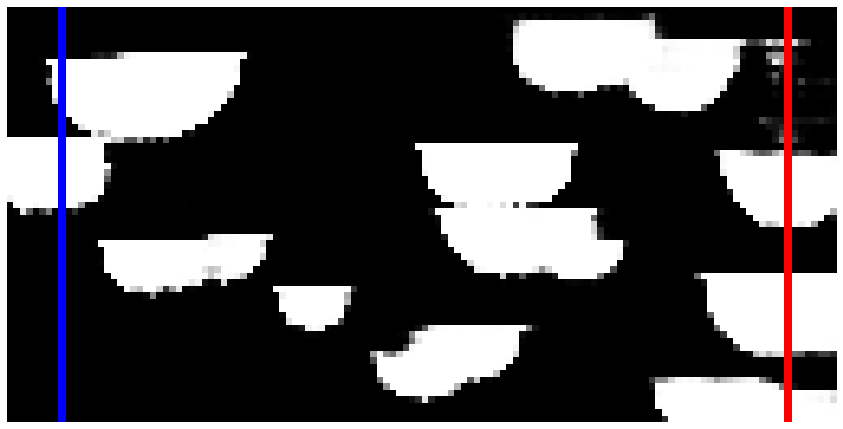

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sc1 = ax.imshow(perms[1, ::-1], cmap="gray")
#colorbar(sc1)
ax.set_xticks([])
ax.set_yticks([])

ax.axvline(8, color="blue", linewidth=8)
ax.axvline(120, color="red", linewidth=8)

ax.set_axis_off()

fig.tight_layout()


if plot:
    plt.savefig("./results/figures/perm_case_66_iteration_1.png", dpi=300, bbox_inches="tight")

## Additional Graphs for Overview Figure - Porosity

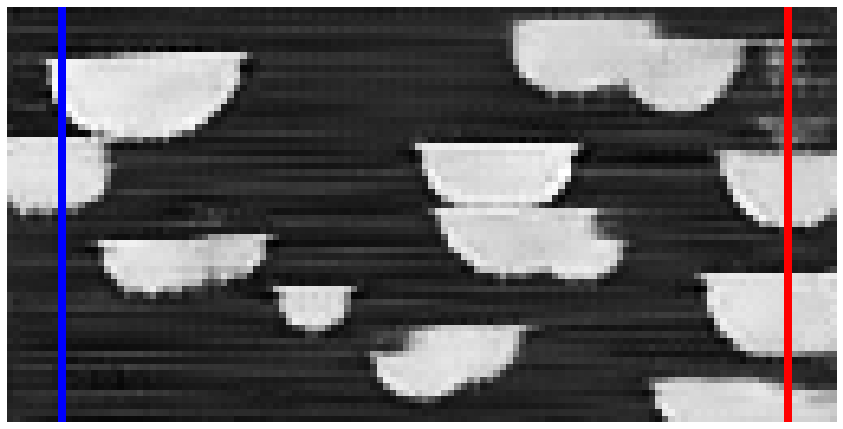

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sc1 = ax.imshow(poros[1, ::-1], cmap="gray")
#colorbar(sc1)
ax.set_xticks([])
ax.set_yticks([])

ax.axvline(8, color="blue", linewidth=8)
ax.axvline(120, color="red", linewidth=8)

ax.set_axis_off()

fig.tight_layout()
if plot:
    plt.savefig("./results/figures/poro_case_66_iteration_1.png", dpi=300, bbox_inches="tight")

## Additional Graphs for Overview Figure - Flow Functional

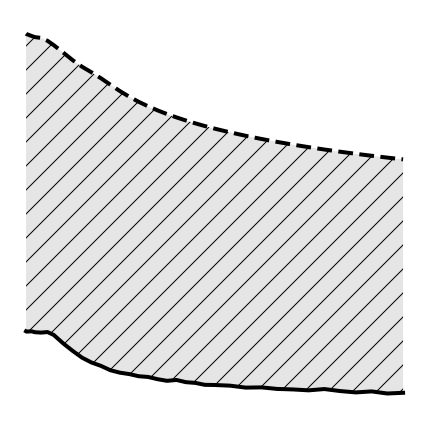

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

x = dts
y1 = curves_case[1, 2]
y2 = ref_curves[2]
ax.plot(dts, y1, linewidth=4, color='black', alpha=1.0, linestyle="--", label="Simulated")
ax.plot(dts, y2, color="black", linewidth=4, linestyle="-", label="Observed")

ax.fill_between(x, y1, y2, where=y2 < y1, facecolor='grey', alpha=0.2, hatch = '/', interpolate=True)

ax.set_yscale("log")
ax.set_ylim(150, 20000)

ax.set_xticks([])
ax.set_yticks([])

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_axis_off()

fig.tight_layout()
if plot:
    plt.savefig("./results/figures/pressure_functional_new.png", dpi=300, bbox_inches="tight")